In [1]:
%load_ext autoreload
%autoreload 2

## Initial Code Setup

In [2]:
#Import Packages
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

import os

from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#Import custom classes
from Source.NN_model_2 import QNetwork
from Source.dqn_agent_2 import Agent, ReplayBuffer, EpsilonGreedyStrategy
from Source.Env_Manager import EnvManager
from Source.Misc import plot

import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep
from datetime import date

In [3]:
#Hyper-parameters
BUFFER_SIZE = int(1e5)      #replay buffer size
BATCH_SIZE = 60             #minibatch size
GAMMA = 0.999                #discount factor
LR = 5e-4                   #learning rate
UPDATE_EVERY = 50            #how often to update the network
EPISODE_REPEAT = 300            #no. of simulations performed on each episode  
SEED = 0                    #random seed number

TAU = 1e-3                  #for soft update of target parameters
EPS_START = 1
EPS_END = 0.01
EPS_DECAY = 0.9983 #125e-6
EPISODE_STEP_LIMIT = 50
TRAIN_EPISODES = 2800
TEST_EPISODES = 20

#Choose the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



def Initialize_Setup():
    #Choose the environment
    em = EnvManager(device, 'uav-v3', SEED)
    available_actions = em.num_actions_available()
    random.seed(SEED)

    #Select the strategy
    strategy = EpsilonGreedyStrategy(EPS_START, EPS_END, EPS_DECAY)

    #Initialize the agent
    agent = Agent(strategy, available_actions, SEED, device)

    #Instantiate MemoryBuffer
    memory = ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, SEED, device)

    policy_net = QNetwork(available_actions, SEED).to(device)
    target_net = QNetwork(available_actions, SEED).to(device)
    #print(policy_net)

    #Initialize target_net weights to policy_net weights
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval() #Set the target_net in eval mode

    #Select the optimizer
    optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)
    return em, strategy, agent, memory, policy_net, target_net, optimizer

em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
measure = 'rate_thr_path'

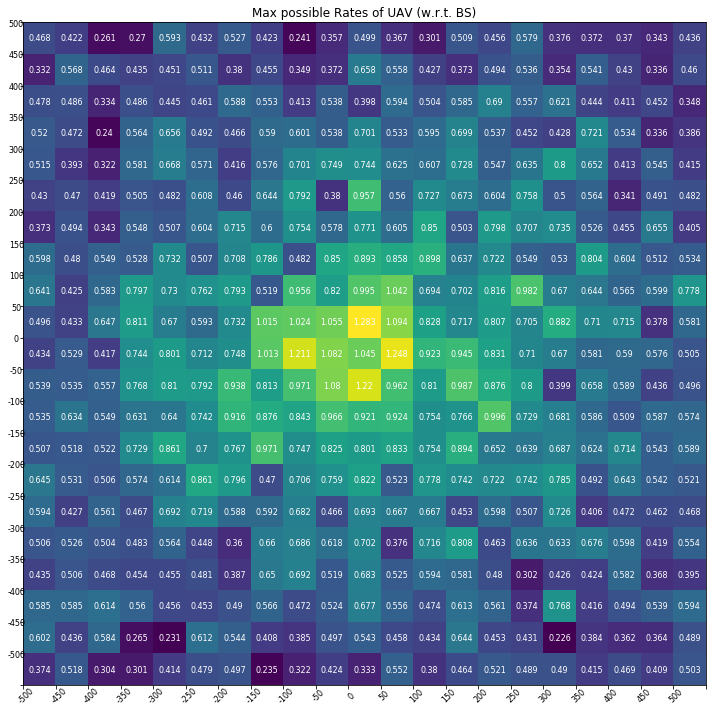

In [4]:
exh_rates_fname = 'env_exh_rates.txt'
ue_xloc = em.env.ue_xloc  #20 locs
ue_yloc = em.env.ue_yloc[::-1]     #20 locs

if os.path.exists(exh_rates_fname):
    rate_arr = np.loadtxt(exh_rates_fname, dtype=float)
else:
    # File is empty
    rate_tr = 0.0
    t_step = 0

    rate_arr = np.zeros([(max(ue_yloc)-min(ue_yloc))//50 +1, (max(ue_xloc)-min(ue_xloc))//50 + 1]) #(-500,50) -----> (500,500)
    for y_ndx in range(len(ue_yloc)):
        for x_ndx in range(len(ue_xloc)):
            state = np.array([ue_xloc[x_ndx], ue_yloc[y_ndx]])/ em.env.high_obs
            exh_bdir,exh_rate = em.env.get_Exh_Rate(state)
            rate_arr[y_ndx,x_ndx] = np.around(exh_rate, decimals=3)
    np.savetxt(exh_rates_fname, rate_arr, fmt='%f')

row_labels = [str(x) for x in ue_yloc]
col_labels = [str(x) for x in ue_xloc]

fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(rate_arr, aspect='auto')

# We want to show all ticks...
ax.set_xticks(np.arange(rate_arr.shape[1]+1)-.5)
ax.set_yticks(np.arange(rate_arr.shape[0]+1)-.5)
# ... and label them with the respective list entries
ax.set_xticklabels(col_labels, fontsize=8)
ax.set_yticklabels(row_labels, fontsize=8)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="center",
         rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(rate_arr.shape[0]):
    for j in range(rate_arr.shape[1]):
        text = ax.text(j, i, rate_arr[i, j],
                       ha="center", va="center", color="w", fontsize=8)

ax.set_title("Max possible Rates of UAV (w.r.t. BS)")
fig.tight_layout()
plt.show()    



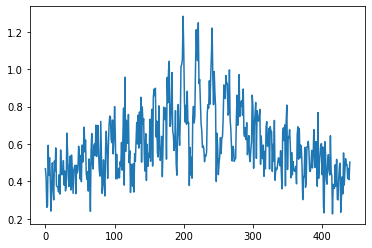

In [5]:
rate_arr = rate_arr.flatten()
#print(rate_arr[160])
plt.plot(rate_arr)
plt.show()

In [6]:
rate_thr_indices = [24, 175, 80, 157, 179, 284]

for i in rate_thr_indices:
    print(rate_arr[i])

0.435
0.519
0.721
0.893
1.042
0.833


In [7]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [8]:
def Training_Loop(policy_net, target_net, memory, em, agent, optimizer, train_episodes, rate_thr, rate_ndx, measure):
    episode_durations = []
    episode_rewards = []
    policy_net.train()

    outer = tqdm.tqdm_notebook(total=train_episodes, desc='{1}: {0}-training loop: '.format(rate_ndx, measure), position=0)

    for episode in range(train_episodes):
        #Set the rate requirement and reset environment
        state_indices = em.env.obs_space.sample()
        state = em.reset(rate_thr, measure, state_indices)
        
        ep_loss, ep_rwd, timestep = 0.0, 0.0, 0

        #Count the steps in agent
        agent.current_step +=1      
        for timestep in count():
            action = agent.act(state, policy_net)    
            next_state, reward, done, _ = em.step(action)
            ep_rwd += reward.item()
            memory.add(state, action, reward, next_state, done)

            state = next_state

            if memory.can_provide_sample():
                experiences = memory.sample()
                states, actions, rewards, next_states, dones = experiences

                current_q_values = policy_net(states).gather(1,index=actions.unsqueeze(-1))
                next_q_values = target_net(next_states).detach().max(1)[0]
                target_q_values = (next_q_values*GAMMA) + rewards

                loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
                ep_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if (timestep==EPISODE_STEP_LIMIT) or done:
                episode_durations.append(timestep)
                episode_rewards.append(ep_rwd/(timestep+1))
                print('\rEpisode {}\t timestep: {}, Score: {:.2f}, eps: {}'.format(episode+1, timestep, ep_rwd, agent.strategy.get_exploration_rate(agent.current_step)), end="\r")
                break
                                
        if episode % UPDATE_EVERY == 0:
            target_net.load_state_dict(policy_net.state_dict())
            
        # update tqdm outer progress bar
        outer.update(1)
    torch.save(policy_net.state_dict(), 'model_{0}_051119_{1}.pth'.format(measure, rate_ndx))
    np.savetxt('{0}_rewards_051119_{1}.txt'.format(measure, rate_ndx), np.array(episode_rewards), fmt='%f')
    np.savetxt('{0}_durations_051119_{1}.txt'.format(measure, rate_ndx), np.array(episode_durations), fmt='%f')
    return episode_rewards, episode_durations

## 1. Training over different rate threshold

rate_threshold:  0.435




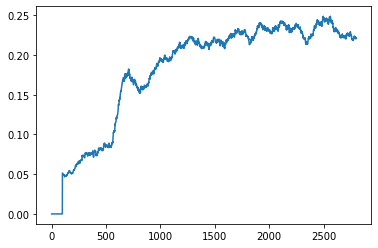

rate_threshold:  0.519


Episode 2800	 timestep: 10, Score: 3.88, eps: 0.010010561361234933



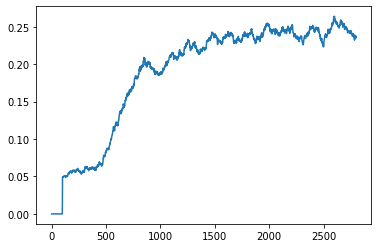

rate_threshold:  0.721




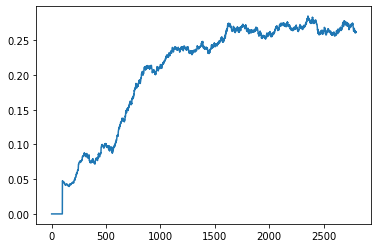

rate_threshold:  0.893




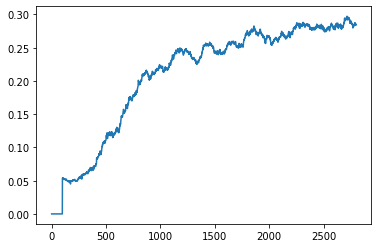

In [77]:
rate_thr_indices = [24, 175, 80, 157]
rate_thr_rwd_fname = 'rate_thr_rewards.txt'
rate_thr_dur_fname = 'rate_thr_durations.txt'
measure = 'rate_thr_path'

rate_thr_episode_rewards = []
rate_thr_episode_durations = []
for rate_ndx in rate_thr_indices:
    print("rate_threshold: ", rate_arr[rate_ndx])
    
    #Re-Initialize Setup
    em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
    rate_thr = rate_arr[rate_ndx]
    
    rate_thr_fname = 'model_' + measure + '_051119_' + str(rate_ndx) + '.pth'
    if os.path.exists(rate_thr_fname):
        episode_rewards = np.loadtxt(measure + '_rewards_051119_' + str(rate_ndx) + '.txt')
        episode_durations = np.loadtxt(measure + '_durations_051119_' + str(rate_ndx) + '.txt')
        episode_rewards = episode_rewards.tolist()
        episode_durations = episode_durations.tolist()
    else:
        #Training Loop
        episode_rewards, episode_durations = Training_Loop(policy_net, target_net, memory,em, agent, optimizer, TRAIN_EPISODES, rate_thr, rate_ndx, measure)
    
    print("\n")
    rate_thr_episode_rewards.append(episode_rewards)
    rate_thr_episode_durations.append(episode_durations)
    moving_avg = get_moving_average(100, episode_rewards)
    plt.plot(moving_avg)
    plt.show()

np.savetxt(rate_thr_rwd_fname, np.array(rate_thr_episode_rewards), fmt='%f')
np.savetxt(rate_thr_dur_fname, np.array(rate_thr_episode_durations), fmt='%f')



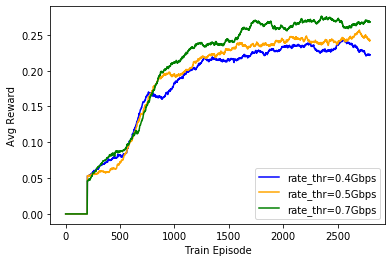

In [78]:
#Plot the figures
rate_thr_rwd_fname = 'rate_thr_rewards.txt'
rate_thr_episode_rewards = np.loadtxt(rate_thr_rwd_fname)
rate_thr = [0.435, 0.519,0.721,0.893]
plt.figure()
plt.clf()
#plt.title('Training...')
plt.xlabel('Train Episode')
plt.ylabel('Avg Reward')
moving_avg_period = 200

moving_avg0 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[0])
plt.plot(moving_avg0, color='blue', label='rate_thr={0}Gbps'.format(np.around(rate_arr[rate_thr_indices[0]], decimals=1)))

moving_avg1 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[1])
plt.plot(moving_avg1, color='orange', label='rate_thr={0}Gbps'.format(np.around(rate_arr[rate_thr_indices[1]], decimals=1)))


moving_avg2 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[2])
plt.plot(moving_avg2, color='green', label='rate_thr={0}Gbps'.format(np.around(rate_arr[rate_thr_indices[2]], decimals=1)))    
plt.legend()
#plt.savefig('rwd_fn_plot_051119.pdf')
plt.show()

## 2. Path plot rate_threshold vs shortest path vs rate path

In [13]:
#rate_threshold path
rate_ndx = 175 #3 Mbps
#Re-Initialize Setup

em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
rate_thr = rate_arr[rate_ndx]
measure = 'rate_thr_path'

rate_thr_fname = 'model_' + measure + '_051119_' + str(rate_ndx) + '.pth'
if os.path.exists(rate_thr_fname):
    rate_thr_episode_rewards = np.loadtxt(measure + '_rewards_051119_' + str(rate_ndx) + '.txt')
    rate_thr_episode_durations = np.loadtxt(measure + '_durations_051119_' + str(rate_ndx) + '.txt')
    rate_thr_episode_rewards = rate_thr_episode_rewards.tolist()
    rate_thr_episode_durations = rate_thr_episode_durations.tolist()
else:
    #Training Loop
    rate_thr_episode_rewards, rate_thr_episode_durations = Training_Loop(policy_net, target_net, memory, em, agent, optimizer, TRAIN_EPISODES, rate_thr, rate_ndx, measure)
    print("\n")
    #rate_thr_path_rates = em.env.ue_path_rates
    #rate_thr_path = em.env.ue_path_rates

#-------------------------------------------------------------------------------------------------------------------------------
#shortest path

#Re-Initialize Setup
em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
rate_thr = rate_arr[rate_ndx]
measure = 'short_path'
#Training Loop
short_episode_rewards, short_episode_durations = Training_Loop(policy_net, target_net, memory, em, agent, optimizer, TRAIN_EPISODES, rate_thr, rate_ndx, measure)
print("\n")
#short_path_rates = em.env.ue_path_rates
#short_path = em.env.ue_path_rates

#------------------------------------------------------------------------------------------------------------------------------
#Rate Path
'''
#Re-Initialize Setup
em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
rate_thr = rate_arr[rate_ndx]
measure = 'rate_path'

#Training Loop
rate_episode_rewards, rate_episode_durations = Training_Loop(policy_net, target_net, memory, em, agent, optimizer, TRAIN_EPISODES, rate_thr, rate_ndx, measure)
print("\n")
rate_path_rates = em.env.ue_path_rates
rate_path = em.env.ue_path_rates
'''

Episode 2800	 timestep: 34, Score: -33.00, eps: 0.010010561361234933



'\n#Re-Initialize Setup\nem, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()\nrate_thr = rate_arr[rate_ndx]\nmeasure = \'rate_path\'\n\n#Training Loop\nrate_episode_rewards, rate_episode_durations = Training_Loop(policy_net, target_net, memory, em, agent, optimizer, TRAIN_EPISODES, rate_thr, rate_ndx, measure)\nprint("\n")\nrate_path_rates = em.env.ue_path_rates\nrate_path = em.env.ue_path_rates\n'

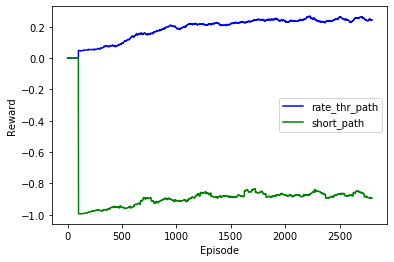

In [14]:
#Plot the figures
plt.figure()
plt.clf()
plt.xlabel('Episode')
plt.ylabel('Reward')
moving_avg_period = 100

moving_avg0 = get_moving_average(moving_avg_period, rate_thr_episode_rewards)
plt.plot(moving_avg0, color='blue', label='rate_thr_path')

#moving_avg1 = get_moving_average(moving_avg_period, rate_episode_rewards)
#plt.plot(moving_avg1, color='orange', label='rate_path')

moving_avg2 = get_moving_average(moving_avg_period, short_episode_rewards)
plt.plot(moving_avg2, color='green', label='short_path')    

plt.legend()
plt.show()

In [107]:
measures=['rate_thr_path', 'short_path']
rate_ndx = 175

#Initialize the setup
em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
src_xndx, src_yndx = em.env.obs_space.sample()

src_loc = np.array([em.env.ue_xloc[src_xndx],em.env.ue_yloc[src_yndx]])
dest_loc = np.array([em.env.ue_xdest[0], em.env.ue_ydest[0]])
gNB_loc = np.array([em.env.gNB[0][0], em.env.gNB[0][1]]) #2D location
ue_paths = []
ue_path_rates=[]
ue_path_exh_rates = []
for meas in measures:
    
    #Initialize the setup
    em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()

    #Load the weights from file
    #policy_net.load_state_dict(torch.load('model_{0}_{1}_{2}.pth'.format(meas, date.today().strftime("%d%m%y"), rate_ndx)))
    policy_net.load_state_dict(torch.load('model_{0}_051119_{1}.pth'.format(meas,rate_ndx)))
    
    policy_net.eval()
    
    state_tensor = em.reset(rate_arr[rate_ndx], meas, (src_xndx, src_yndx))
    
    exh_rates = []
    for t_step in count():
        action = policy_net(state_tensor).argmax(dim=1).to(device)
        next_state_tensor, reward, done, _ = em.step(action)
        
        state = np.rint(state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        next_state = np.rint(next_state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        #print("Current State: ", state)
        #print("Next State: ", next_state)
        
        curr_loc = (state[0], state[1])
        next_loc = (next_state[0], next_state[1])
        
        next_state = next_state / em.env.high_obs
        state = state / em.env.high_obs
        
        state_tensor = torch.tensor(np.array([next_state]), dtype=torch.float32).to(device)
        _, exh_rate = em.env.get_Exh_Rate(next_state)
        
        exh_rates.append(exh_rate)
        if (t_step == EPISODE_STEP_LIMIT) or done:
            break
    ue_paths.append(em.env.ue_path)
    ue_path_rates.append(em.env.ue_path_rates)
    ue_path_exh_rates.append(exh_rates)
#print(ue_paths)

rate thr Count: 24, short path count: 24


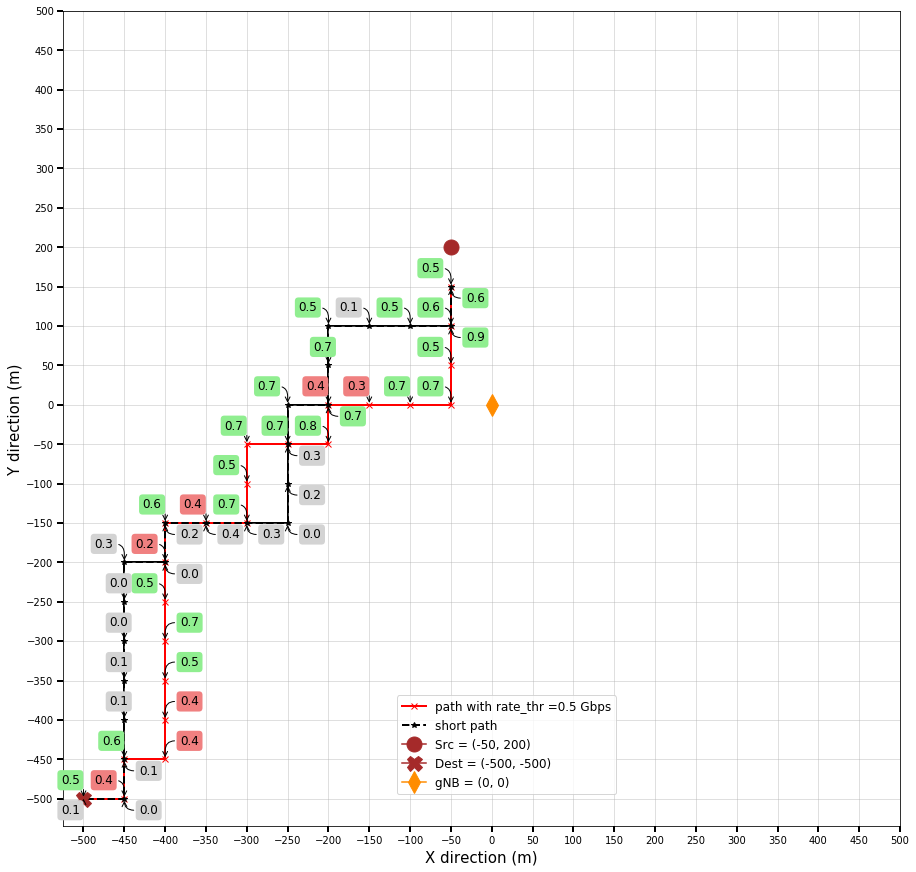

In [109]:
from matplotlib.path import Path
import matplotlib.patches as patches

#rate_thr_path
rate_thr_path = ue_paths[0]
rate_thr_path_rates = ue_path_rates[0]
rate_thr_path_exh_rates = ue_path_exh_rates[0]
rate_thr_verts = [(int(x[0]), int(x[1])) for x in rate_thr_path]
rate_thr_codes = [Path.LINETO for x in range(len(rate_thr_verts))]
rate_thr_codes[0] = Path.MOVETO
rate_thr_codes[-1] = Path.STOP
rate_thr_path  = Path(rate_thr_verts, rate_thr_codes)
rate_ndx = 175
rate_thr = np.around(rate_arr[rate_ndx], decimals=1)

#rate_path
#rate_path = ue_paths[1]
#rate_path_rates = ue_path_rates[1]
#rate_verts = [(int(x[0]), int(x[1])) for x in rate_path]
#rate_codes = [Path.LINETO for x in range(len(rate_verts))]
#rate_codes[0] = Path.MOVETO
#rate_codes[-1] = Path.STOP
#rate_path  = Path(rate_verts, rate_codes)

#short_path
short_path = ue_paths[1]
short_path_rates = ue_path_rates[1]
short_verts = [(int(x[0]), int(x[1])) for x in short_path]
short_codes = [Path.LINETO for x in range(len(short_verts))]
short_codes[0] = Path.MOVETO
short_codes[-1] = Path.STOP
short_path  = Path(short_verts, short_codes)

print("rate thr Count: {}, short path count: {}".format(len(rate_thr_path), len(short_path)))
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
rate_thr_patch = patches.PathPatch(rate_thr_path, facecolor='none', lw=2)
#rate_patch = patches.PathPatch(rate_path, facecolor='none', lw=2)
short_patch = patches.PathPatch(short_path, facecolor='none', lw=2)
ax.add_patch(rate_thr_patch)
#ax.add_patch(rate_patch)
ax.add_patch(short_patch)

rate_thr_xs, rate_thr_ys = zip(*rate_thr_verts)
ax.plot(rate_thr_xs, rate_thr_ys, 'x-', lw=2, color='red', label='path with rate_thr ={} Gbps'.format(rate_thr))

#rate_xs, rate_ys = zip(*rate_verts)
#ax.plot(rate_xs, rate_ys, 'o--', lw=2, color='magenta', label='rate path')

short_xs, short_ys = zip(*short_verts)
ax.plot(short_xs, short_ys, '*--', lw=2, color='black', label='short path')

bbox = dict(boxstyle="round", facecolor='burlywood', edgecolor='none')
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=10")

offset = 50
#Plot src
ax.plot(src_loc[0], src_loc[1], marker='o',markersize=15, color='brown', label='Src = (%d, %d)' % (src_loc[0], src_loc[1]))
#ax.annotate('Src = (%d, %d)' % (src_loc[0], src_loc[1]),
#            (src_loc[0], src_loc[1]), xytext=(-2 * offset, offset), textcoords='offset points',
#            bbox=bbox, arrowprops=arrowprops)

ax.plot(dest_loc[0], dest_loc[1], marker='X',markersize=15, color='brown', label='Dest = (%d, %d)' % (dest_loc[0], dest_loc[1]))
#ax.annotate('Dest = (%d, %d)' % (dest_loc[0], dest_loc[1]),
#                   (dest_loc[0], dest_loc[1]), xytext=(0.5 * offset, -0.25*offset),
#                   textcoords='offset points',
#                   bbox=bbox, arrowprops=arrowprops)

#Plot gNB
bbox = dict(boxstyle="round", facecolor='burlywood', edgecolor='none')
arrowprops1 = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=135,rad=10")
ax.plot(gNB_loc[0], gNB_loc[1], marker='d', markersize=15, color='darkorange', label='gNB = (%d, %d)' % (gNB_loc[0], gNB_loc[1]))
#ax.annotate('gNB = (%d, %d)' % (gNB_loc[0], gNB_loc[1]),
#                   (gNB_loc[0], gNB_loc[1]), xytext=(-2 * offset, 1*offset),
#                   textcoords='offset points',
#                   bbox=bbox, arrowprops=arrowprops1)



#Annotate rate values on short and proposed rate_thr path 
offset= 15
for i in range(0,len(short_path_rates)-1):
    xytext2 = (-2 * offset, offset)
    
    if (i== (len(short_path_rates)-2)):
        xytext1=(-1.5 * offset, -1*offset)
    elif((short_verts[i][0], short_verts[i][1]) == (rate_thr_verts[i][0], rate_thr_verts[i][1])):
        xytext1=(1 * offset, -1*offset)
    elif (i>0) and (short_verts[i][0] < short_verts[i-1][0]):
        xytext1=(-2 * offset, 1*offset)
    elif(short_verts[i][0] < rate_thr_verts[i][0]):
        xytext1=(-1 * offset, 1*offset)
        xytext2=(1 * offset, 1*offset)
    elif(short_verts[i][0] > rate_thr_verts[i][0]):
        xytext1=(1 * offset, -1*offset)
   
    else:
        xytext1=(-1 * offset, -1*offset)
        
    if (np.around(short_path_rates[i], decimals=1) >= rate_thr):
        facecolor1 = 'lightgreen'
    else:
        facecolor1 = 'lightgrey'
    
    
    if(i>0) and (rate_thr_verts[i][0] < rate_thr_verts[i-1][0]):
        xytext2=(-1.5 * offset, 1*offset)
           
    if (np.around(rate_thr_path_rates[i], decimals=1) >= rate_thr):
        facecolor2 = 'lightgreen'
    else:
        facecolor2 = 'lightcoral'

    bbox1 =dict(boxstyle="round", facecolor=facecolor1, edgecolor='none')
    ax.annotate('{0:.1f}'.format(np.around(short_path_rates[i], decimals=1)) ,
                (short_verts[i][0], short_verts[i][1]), xytext=xytext1, textcoords='offset points',
                bbox=bbox1, arrowprops=arrowprops,size=12)
    
    bbox2 =dict(boxstyle="round", facecolor=facecolor2, edgecolor='none')
    
    ax.annotate('{0:.1f}'.format(np.around(rate_thr_path_rates[i], decimals=1)) ,
                (rate_thr_verts[i][0], rate_thr_verts[i][1]), xytext=xytext2, textcoords='offset points',
                bbox=bbox2, arrowprops=arrowprops,size=12)

ax.grid(alpha=0.5)
ax.set_xticks(em.env.ue_xloc)
ax.set_yticks(em.env.ue_yloc)
ax.tick_params(direction='out', length=6, width=2)
#ax.set_title("UAV graph w.r.t gNB [0,0,0]")
ax.set_xlabel("X direction (m)", fontsize=15)
ax.set_ylabel("Y direction (m)", fontsize=15)
ax.legend(loc='center', bbox_to_anchor=(0.28, -0.15, .5, .5), fontsize='large')
plt.savefig('rate_thr_test_episode_051119.jpeg')
plt.show()

## 3. No. of steps done vs rate threshold (between same source and destination)

In [17]:
measures=['rate_thr_path', 'short_path']

TEST_EPISODES = 20

#Initialize the setup
em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()  

models =['model_rate_thr_path_051119_175.pth', 'model_rate_thr_path_051119_80.pth', 'model_rate_thr_path_051119_157.pth', 'model_short_path_051119_175.pth']

model_ep_tsteps = []
model_ep_ue_paths=[]
model_ep_ue_path_rates = []
model_ep_ue_exh_rates = []
#get the 3 models with rate_thr approach, get the model with short_path_approach
#.... compare the number of steps over different episodes
state_indices_list = []
for episode in range(TEST_EPISODES):
    state_indices = em.env.obs_space.sample()
    state_indices_list.append(state_indices)
print(state_indices_list)

for model in models:
    #Load the weights from file
    print('Loading {} ...'.format(model))
    policy_net.load_state_dict(torch.load(model))
    policy_net.eval()

    #identify measure id and rate_thr
    meas_id = model.split('_')[1]
    rate_thr = rate_arr[int(model.split('_')[-1].split('.')[0])]
    
    model_tsteps=[]
    model_ue_paths =[]
    model_ue_path_rates =[]
    model_ue_exh_rates = []
    for state_indices in state_indices_list:
    
        #Env Reset based on measure id
        if(meas_id =='short'):
            state_tensor = em.reset(rate_thr, 'short_path', state_indices)
        else:
            state_tensor = em.reset(rate_thr, 'rate_thr_path', state_indices)
        
        step_count = 0
        exh_rates = []
        #Run Episode with the model
        for t_step in count():
            action = policy_net(state_tensor).argmax(dim=1).to(device)
            next_state_tensor, reward, done, _ = em.step(action)
            
            state = np.rint(state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
            next_state = np.rint(next_state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
            
            curr_loc = (state[0], state[1])
            next_loc = (next_state[0], next_state[1])
            
            next_state = next_state / em.env.high_obs
            state = state / em.env.high_obs
            state_tensor = torch.tensor(np.array([next_state]), dtype=torch.float32).to(device)
            
            step_count+=1
            _,exh_rate = em.env.get_Exh_Rate(next_state)
            
            exh_rates.append(exh_rate)
            if (t_step == EPISODE_STEP_LIMIT) or done:
                model_tsteps.append(step_count)
                print("rate_thr: {}, measure id: {}, count: {}".format(rate_thr, meas_id, step_count))
                model_ue_paths.append(em.env.ue_path)
                model_ue_path_rates.append(em.env.ue_path_rates)
                model_ue_exh_rates.append(exh_rates)
                break
    
    #Collect ep tsteps of each model
    model_ep_tsteps.append(model_tsteps)
    model_ep_ue_paths.append(model_ue_paths)
    model_ep_ue_path_rates.append(model_ue_path_rates)
    model_ep_ue_exh_rates.append(model_ue_exh_rates)
    
    print("\n\n")
    


[array([5, 9], dtype=int64), array([ 6, 16], dtype=int64), array([19, 13], dtype=int64), array([ 7, 10], dtype=int64), array([12, 14], dtype=int64), array([ 9, 16], dtype=int64), array([13, 15], dtype=int64), array([15,  5], dtype=int64), array([20,  1], dtype=int64), array([18, 16], dtype=int64), array([5, 2], dtype=int64), array([2, 0], dtype=int64), array([ 9, 12], dtype=int64), array([10, 14], dtype=int64), array([14, 16], dtype=int64), array([4, 5], dtype=int64), array([10,  4], dtype=int64), array([7, 0], dtype=int64), array([14, 15], dtype=int64), array([14,  1], dtype=int64)]
Loading model_rate_thr_path_051119_175.pth ...
rate_thr: 0.519, measure id: rate, count: 15
rate_thr: 0.519, measure id: rate, count: 23
rate_thr: 0.519, measure id: rate, count: 33
rate_thr: 0.519, measure id: rate, count: 18
rate_thr: 0.519, measure id: rate, count: 27
rate_thr: 0.519, measure id: rate, count: 26
rate_thr: 0.519, measure id: rate, count: 29
rate_thr: 0.519, measure id: rate, count: 21
ra

[array([-200.,  250.]), array([-200.,  200.]), array([-200.,  150.]), array([-200.,  100.]), array([-200.,   50.]), array([-200.,    0.]), array([-200.,  -50.]), array([-200., -100.]), array([-250., -100.]), array([-250., -150.]), array([-300., -150.]), array([-300., -200.]), array([-350., -200.]), array([-350., -250.]), array([-400., -250.]), array([-400., -300.]), array([-450., -300.]), array([-450., -350.]), array([-450., -400.]), array([-450., -450.]), array([-450., -500.]), array([-500., -500.]), array([-500., -500.])]
[array([-200.,  250.]), array([-200.,  200.]), array([-200.,  150.]), array([-200.,  100.]), array([-200.,   50.]), array([-200.,    0.]), array([-200.,  -50.]), array([-250.,  -50.]), array([-250., -100.]), array([-300., -100.]), array([-350., -100.]), array([-350., -150.]), array([-400., -150.]), array([-400., -200.]), array([-400., -250.]), array([-450., -250.]), array([-450., -300.]), array([-450., -350.]), array([-450., -400.]), array([-450., -450.]), array([-5

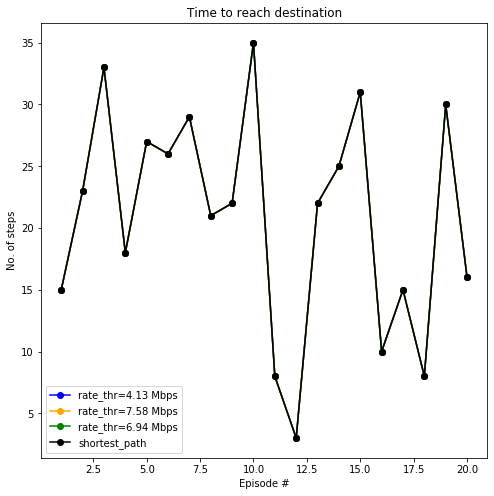

In [18]:
print(model_ep_ue_paths[0][1])
print(model_ep_ue_paths[1][1])
#print(model_ep_ue_path_rates[0][0])
#print(model_ep_ue_path_rates[1][0])
#print(model_ep_tsteps)
#Plot the graph in the end
x_axis = list(np.arange(1, TEST_EPISODES+1))
fig = plt.figure(figsize=(8,8))
plt.plot(x_axis, model_ep_tsteps[0], 'o-', color='blue', label='rate_thr={:.2f} Mbps'.format(10*rate_arr[50]))

plt.plot(x_axis, model_ep_tsteps[1], 'o-', color='orange', label='rate_thr={:.2f} Mbps'.format(10*rate_arr[120]))

plt.plot(x_axis, model_ep_tsteps[2], 'o-', color='green', label='rate_thr={:.2f} Mbps'.format(10*rate_arr[180]))

plt.plot(x_axis, model_ep_tsteps[3], 'o-', color='black', label='shortest_path')

plt.title('Time to reach destination')
plt.xlabel('Episode #')
plt.ylabel('No. of steps')
plt.legend()
plt.show()


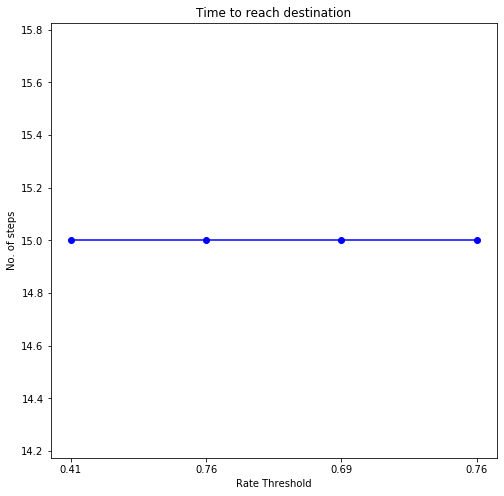

In [21]:
#no. of steps vs rate threshold between same source and destination
x_axis = list(np.arange(1, len(models)+1))
y_axis = [model_ep_tsteps[i][0] for i in range(0,len(model_ep_tsteps))]

fig = plt.figure(figsize=(8,8))
plt.plot(x_axis, y_axis, 'o-', color='blue')

plt.title('Time to reach destination')
plt.xlabel('Rate Threshold')
plt.ylabel('No. of steps')
plt.xticks(np.array(x_axis), [str(np.around(1*rate_arr[x], decimals=2)) for x in [50,120,180,120]])
plt.show()

## 4. Performance Score vs rate threshold, Efficiceny score vs rate threshold (over episode #)

rate_threshold:  0.435




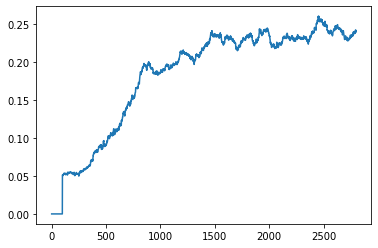

rate_threshold:  0.519




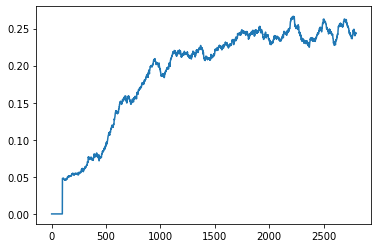

rate_threshold:  0.721




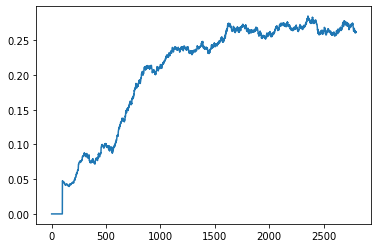

rate_threshold:  0.893




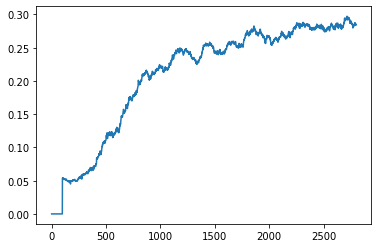

rate_threshold:  1.042


Episode 2800	 timestep: 23, Score: 5.44, eps: 0.010010561361234933



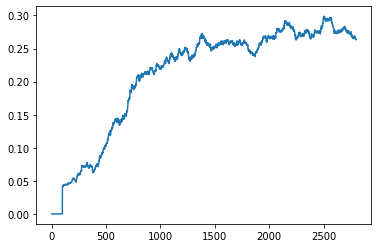

rate_threshold:  0.833


Episode 2800	 timestep: 4, Score: 2.56, eps: 0.0110010561361234933



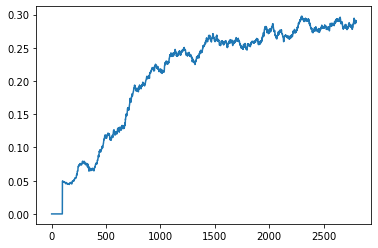

In [22]:
rate_thr_indices = [24, 175, 80, 157, 179, 284]
rate_thr_rwd_fname = 'rate_thr_rewards.txt'
rate_thr_dur_fname = 'rate_thr_durations.txt'
measure = 'rate_thr_path'

rate_thr_episode_rewards = []
rate_thr_episode_durations = []
for rate_ndx in rate_thr_indices:
    print("rate_threshold: ", rate_arr[rate_ndx])
    
    #Re-Initialize Setup
    em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
    rate_thr = rate_arr[rate_ndx]
    
    rate_thr_fname = 'model_' + measure + '_051119_' + str(rate_ndx) + '.pth'
    if os.path.exists(rate_thr_fname):
        episode_rewards = np.loadtxt(measure + '_rewards_051119_' + str(rate_ndx) + '.txt')
        episode_durations = np.loadtxt(measure + '_durations_051119_' + str(rate_ndx) + '.txt')
        episode_rewards = episode_rewards.tolist()
        episode_durations = episode_durations.tolist()
    else:
        #Training Loop
        episode_rewards, episode_durations = Training_Loop(policy_net, target_net, memory,em, agent, optimizer, TRAIN_EPISODES, rate_thr, rate_ndx, measure)

    print("\n")
    rate_thr_episode_rewards.append(episode_rewards)
    rate_thr_episode_durations.append(episode_durations)
    moving_avg = get_moving_average(100, episode_rewards)
    plt.plot(moving_avg)
    plt.show()

np.savetxt(rate_thr_rwd_fname, np.array(rate_thr_episode_rewards), fmt='%f')
np.savetxt(rate_thr_dur_fname, np.array(rate_thr_episode_durations), fmt='%f')


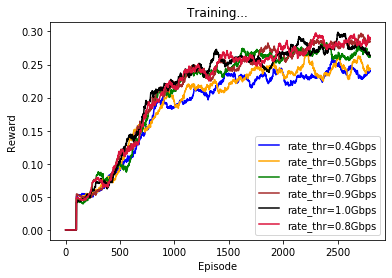

In [23]:
#Plot the figures
plt.figure()
plt.clf()
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Reward')
moving_avg_period = 100

moving_avg0 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[0])
plt.plot(moving_avg0, color='blue', label='rate_thr={0}Gbps'.format(np.around(rate_arr[rate_thr_indices[0]], decimals=1)))

moving_avg1 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[1])
plt.plot(moving_avg1, color='orange', label='rate_thr={0}Gbps'.format(np.around(rate_arr[rate_thr_indices[1]], decimals=1)))


moving_avg2 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[2])
plt.plot(moving_avg2, color='green', label='rate_thr={0}Gbps'.format(np.around(rate_arr[rate_thr_indices[2]], decimals=1)))

moving_avg3 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[3])
plt.plot(moving_avg3, color='brown', label='rate_thr={0}Gbps'.format(np.around(rate_arr[rate_thr_indices[3]], decimals=1)))

moving_avg4 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[4])
plt.plot(moving_avg4, color='black', label='rate_thr={0}Gbps'.format(np.around(rate_arr[rate_thr_indices[4]], decimals=1)))

moving_avg5 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[5])
plt.plot(moving_avg5, color='crimson', label='rate_thr={0}Gbps'.format(np.around(rate_arr[rate_thr_indices[5]], decimals=1)))

plt.legend()
plt.show()

In [240]:
#This cell is mainly to compute the episode paths and rates along the path for different rate threshold methods

measures=['rate_thr_path']

TEST_EPISODES = 40
rate_thr_indices = [175, 80, 284, 157, 179]
#Initialize the setup
em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()  

models =['model_rate_thr_path_051119_{}.pth'.format(x) for x in rate_thr_indices]


model_ep_tsteps = []
model_ep_ue_paths=[]
model_ep_ue_path_rates = []
model_ep_ue_exh_rates = []
#get the 3 models with rate_thr approach, get the model with short_path_approach
#.... compare the number of steps over different episodes
state_indices_list = []
for episode in range(TEST_EPISODES):
    state_indices = em.env.obs_space.sample()
    state_indices_list.append(state_indices)
print(state_indices_list)

for model in models:
    #Load the weights from file
    print('Loading {} ...'.format(model))
    policy_net.load_state_dict(torch.load(model))
    policy_net.eval()

    #identify measure id and rate_thr
    meas_id = model.split('_')[1]
    rate_thr = rate_arr[int(model.split('_')[-1].split('.')[0])]
    
    model_tsteps=[]
    model_ue_paths =[]
    model_ue_path_rates =[]
    model_ue_exh_rates = []
    for state_indices in state_indices_list:
    
        #Env Reset based on measure id
        if(meas_id =='short'):
            state_tensor = em.reset(rate_thr, 'short_path', state_indices)
        else:
            state_tensor = em.reset(rate_thr, 'rate_thr_path', state_indices)
        
        step_count = 0
        exh_rates = []
        #Run Episode with the model
        for t_step in count():
            action = policy_net(state_tensor).argmax(dim=1).to(device)
            next_state_tensor, reward, done, _ = em.step(action)
            
            state = np.rint(state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
            next_state = np.rint(next_state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
            
            curr_loc = (state[0], state[1])
            next_loc = (next_state[0], next_state[1])
            
            next_state = next_state / em.env.high_obs
            state = state / em.env.high_obs
            state_tensor = torch.tensor(np.array([next_state]), dtype=torch.float32).to(device)
            
            step_count+=1
            _,exh_rate = em.env.get_Exh_Rate(next_state)
            
            exh_rates.append(exh_rate)
            if (t_step == EPISODE_STEP_LIMIT) or done:
                model_tsteps.append(step_count)
                print("rate_thr: {}, measure id: {}, count: {}".format(rate_thr, meas_id, step_count))
                model_ue_paths.append(em.env.ue_path)
                model_ue_path_rates.append(em.env.ue_path_rates)
                model_ue_exh_rates.append(exh_rates)
                break
    
    #Collect ep tsteps of each model
    model_ep_tsteps.append(model_tsteps)
    model_ep_ue_paths.append(model_ue_paths)
    model_ep_ue_path_rates.append(model_ue_path_rates)
    model_ep_ue_exh_rates.append(model_ue_exh_rates)
    
    print("\n\n")
    

[array([11,  9], dtype=int64), array([10,  7], dtype=int64), array([5, 2], dtype=int64), array([12, 16], dtype=int64), array([7, 0], dtype=int64), array([ 6, 12], dtype=int64), array([15, 11], dtype=int64), array([ 0, 20], dtype=int64), array([10, 10], dtype=int64), array([ 0, 11], dtype=int64), array([15, 20], dtype=int64), array([17,  5], dtype=int64), array([14,  5], dtype=int64), array([13,  0], dtype=int64), array([19, 16], dtype=int64), array([ 0, 18], dtype=int64), array([2, 5], dtype=int64), array([16, 10], dtype=int64), array([17,  4], dtype=int64), array([11, 17], dtype=int64), array([ 3, 14], dtype=int64), array([16, 18], dtype=int64), array([19, 12], dtype=int64), array([ 1, 13], dtype=int64), array([ 4, 18], dtype=int64), array([ 6, 15], dtype=int64), array([16, 18], dtype=int64), array([17, 12], dtype=int64), array([13,  8], dtype=int64), array([18,  1], dtype=int64), array([16, 15], dtype=int64), array([19,  5], dtype=int64), array([20, 15], dtype=int64), array([ 9, 19],

rate_thr: 0.893, measure id: rate, count: 25
rate_thr: 0.893, measure id: rate, count: 36
rate_thr: 0.893, measure id: rate, count: 29
rate_thr: 0.893, measure id: rate, count: 4
rate_thr: 0.893, measure id: rate, count: 11
rate_thr: 0.893, measure id: rate, count: 16
rate_thr: 0.893, measure id: rate, count: 14
rate_thr: 0.893, measure id: rate, count: 28
rate_thr: 0.893, measure id: rate, count: 5



Loading model_rate_thr_path_051119_179.pth ...
rate_thr: 1.042, measure id: rate, count: 21
rate_thr: 1.042, measure id: rate, count: 18
rate_thr: 1.042, measure id: rate, count: 8
rate_thr: 1.042, measure id: rate, count: 29
rate_thr: 1.042, measure id: rate, count: 8
rate_thr: 1.042, measure id: rate, count: 19
rate_thr: 1.042, measure id: rate, count: 27
rate_thr: 1.042, measure id: rate, count: 21
rate_thr: 1.042, measure id: rate, count: 21
rate_thr: 1.042, measure id: rate, count: 12
rate_thr: 1.042, measure id: rate, count: 36
rate_thr: 1.042, measure id: rate, count: 23
rate_thr:

In [231]:
#print(rate_arr[rate_thr_indices[0]])
#print(model_ep_ue_path_rates)
a1 = np.around(model_ep_ue_path_rates[1][0][:], decimals=3)
a2 = np.around([x/0.9917 for x in model_ep_ue_exh_rates[1][0][:]], decimals=3)
print((np.sum(a1)/np.sum(a2))*64)

#print(model_ep_ue_exh_rates)
#print(em.env.N_rx)


55.67510300176574


56.720000000000006


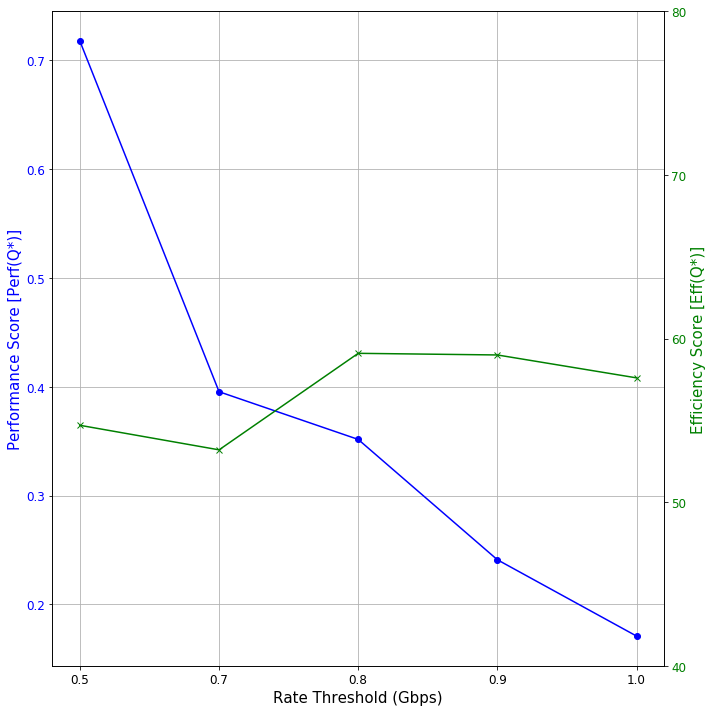

In [243]:
model_perf_scores = []
model_eff_scores = []
for model_ndx in range(len(model_ep_ue_path_rates)):
    ep_perf_scores = []
    ep_eff_scores = []
    for ep_ndx in range(len(model_ep_ue_path_rates[model_ndx])):
        model_score, exh_score = 0,0
        perf_score = 0.0
        eff_score = 0.0
        for rate_ndx in range(len(model_ep_ue_path_rates[model_ndx][ep_ndx])):
            if model_ep_ue_path_rates[model_ndx][ep_ndx][rate_ndx] >= np.around(rate_arr[rate_thr_indices[model_ndx]], decimals=1):
                model_score += 1
            if model_ep_ue_exh_rates[model_ndx][ep_ndx][rate_ndx] >= rate_arr[rate_thr_indices[model_ndx]]:
                exh_score += 1
        #Compute Efficiency Score
        #if (model_ep_ue_exh_rates[model_ndx][ep_ndx][rate_ndx] > 0):
        a1 = (np.around(np.sum(model_ep_ue_path_rates[model_ndx][ep_ndx][:]), decimals=7))
        a2 = np.around(np.sum(model_ep_ue_exh_rates[model_ndx][ep_ndx][:]),decimals=7)
        eff_score = a1*(em.env.N_rx* em.env.N_tx)/a2
        #Compute performance score
        if exh_score > 0:
            perf_score = float(model_score)/float(exh_score)
        ep_perf_scores.append(perf_score)
        ep_eff_scores.append(eff_score)
        
        
    model_perf_scores.append(ep_perf_scores)
    model_eff_scores.append(ep_eff_scores)
    

x_axis = list(np.arange(1, len(rate_thr_indices)+1))
model_mean_perf_scores = [np.mean(x) for x in model_perf_scores]
model_mean_eff_scores = [np.around(np.mean(x),decimals=1) for x in model_eff_scores]
print(np.mean(model_mean_eff_scores))
#fig = plt.figure(figsize=(8,8))

fig, ax1 = plt.subplots(figsize=(10,10))
#ax1.set_title('Performance and Efficiency', fontsize=15)
ax1.set_xlabel('Rate Threshold (Gbps)', fontsize=15)
ax1.set_ylabel('Performance Score [Perf(Q*)]', color='blue', fontsize=15)
ax1.plot(x_axis, model_mean_perf_scores, 'o-', color='blue')
ax1.tick_params(axis='y', labelcolor='blue', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Efficiency Score [Eff(Q*)]', color='green', fontsize=15)  # we already handled the x-label with ax1
ax2.plot(x_axis, model_mean_eff_scores, 'x-', color='green')
ax2.tick_params(axis='y', labelcolor='green', labelsize=12)
ax2.set_yticks(np.array(range(40,90,10)))

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.xticks(np.array(x_axis), [str(np.around(rate_arr[x], decimals=1)) for x in rate_thr_indices])
#plt.savefig('eff_perf_scores_051119.pdf')
plt.show()


## 5. Plot rate vs distance (Testing phase)

In [157]:
meas='rate_thr_path'
rate_thr_indices = [24, 175,80]#, 175, 280, 179, 262]
rate_thr = [0.435,0.519, 0.721, 0.519]
#Initialize the setup
em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
# select source
src_xndx, src_yndx = em.env.obs_space.sample()

models =['model_rate_thr_path_051119_{}.pth'.format(x) for x in rate_thr_indices]
models.append('model_short_path_051119_175.pth')
src_loc = np.array([em.env.ue_xloc[src_xndx],em.env.ue_yloc[src_yndx]])
dest_loc = np.array([em.env.ue_xdest[0], em.env.ue_ydest[0]])
gNB_loc = np.array([em.env.gNB[0][0], em.env.gNB[0][1]]) #2D location

model_ue_dist = []
ue_paths = []
ue_path_rates = []
ue_path_exh_rates = []
ue_short_path_rates = []
ue_short_dist = []
#Run the episode for each model
for i in range(len(models)):
    #Initialize the setup
    em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
    
    #Load the weights from file
    policy_net.load_state_dict(torch.load(models[i]))
    policy_net.eval()

    if models[i].split('_')[1] == 'short':
        meas =  'short_path'
    else:
        meas = 'rate_thr_path'
        
    state_tensor = em.reset(rate_thr[i], meas, (src_xndx, src_yndx))
    ue_dist=[]
    exh_rates = []
    for t_step in count():
        #if (meas == 'short_path'):
        #    action = torch.tensor([random.randrange(agent.action_size)]).to(device)
        #else:
        action = policy_net(state_tensor).argmax(dim=1).to(device)
        next_state_tensor, reward, done, _ = em.step(action)
        
        state = np.rint(state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        next_state = np.rint(next_state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        #print("Current State: ", state)
        #print("Next State: ", next_state)
        
        curr_loc = (state[0], state[1])
        next_loc = (next_state[0], next_state[1])
        temp = np.array([next_state[0], next_state[1]]) - dest_loc
        dist = np.sqrt(temp[0]**2 + temp[1]**2)
        if(meas == 'short_path'):
            ue_short_dist.append(dist)
        else:
            ue_dist.append(dist)
    
        next_state = next_state / em.env.high_obs
        state = state / em.env.high_obs
        
        state_tensor = torch.tensor(np.array([next_state]), dtype=torch.float32).to(device)
        _, exh_rate = em.env.get_Exh_Rate(next_state)
        
        exh_rates.append(exh_rate)
        if (t_step == EPISODE_STEP_LIMIT) or done:
            break
    ue_paths.append(em.env.ue_path)
    if(meas == 'short_path'):
        ue_short_path_rates.append(em.env.ue_path_rates)
    else:
        ue_path_rates.append(em.env.ue_path_rates)
        model_ue_dist.append(ue_dist)
    ue_path_exh_rates.append(exh_rates)
    

In [180]:
print(src_loc)
print(dest_loc)
print(model_ue_dist)
print(np.cumsum(ue_path_rates[0]))
print(ue_paths[0])
print(ue_short_dist)
print(ue_short_path_rates)

[-50  50]
[-500 -500]
[[672.6812023536855, 640.3124237432849, 610.3277807866851, 583.09518948453, 559.0169943749474, 538.5164807134504, 492.44289008980525, 447.21359549995793, 427.20018726587654, 412.31056256176606, 364.0054944640259, 316.22776601683796, 269.2582403567252, 223.60679774997897, 180.27756377319946, 141.4213562373095, 111.80339887498948, 100.0, 50.0, 0.0, 0.0], [672.6812023536855, 640.3124237432849, 610.3277807866851, 583.09518948453, 540.8326913195984, 514.78150704935, 492.44289008980525, 447.21359549995793, 403.11288741492746, 380.7886552931954, 364.0054944640259, 316.22776601683796, 269.2582403567252, 223.60679774997897, 180.27756377319946, 141.4213562373095, 111.80339887498948, 70.71067811865476, 50.0, 0.0, 0.0], [672.6812023536855, 640.3124237432849, 610.3277807866851, 570.087712549569, 540.8326913195984, 514.78150704935, 471.6990566028302, 447.21359549995793, 427.20018726587654, 380.7886552931954, 364.0054944640259, 316.22776601683796, 269.2582403567252, 254.95097567

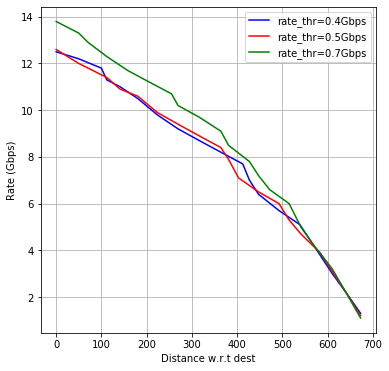

In [159]:
#Plot the exh_rate figures
plt.figure(figsize=(6,6))
plt.clf()
plt.xlabel('Distance w.r.t dest')
plt.ylabel('Rate (Gbps)')

colors = ['blue','red','green']
for i in range(len(models)-1):
    plt.plot(np.around(model_ue_dist[i][:-1], decimals=1), np.around(np.cumsum(ue_path_exh_rates[i][:-1]), decimals=1), color=colors[i], label='rate_thr={0}Gbps'.format(np.around(rate_thr[i], decimals=1)))
plt.grid()
plt.legend()
#plt.savefig('rate_distance_plot_301019.pdf')
plt.show()

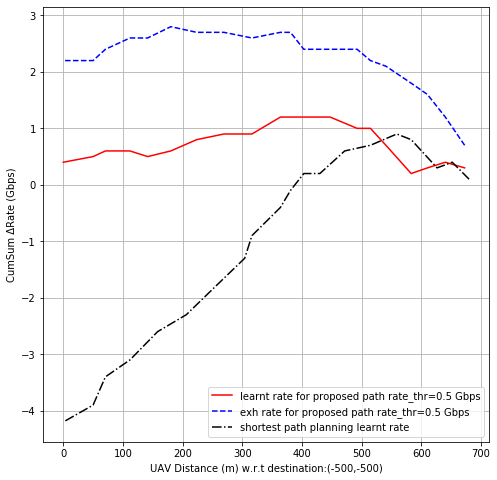

In [169]:
#Plot the figures
plt.figure(figsize=(8,8))
plt.clf()
plt.xlabel('UAV Distance (m) w.r.t destination:({0},{1})'.format(dest_loc[0],dest_loc[1]))
plt.ylabel('CumSum \u0394Rate (Gbps)')

colors = ['blue','red','green']
i=1

exh_rate_change = np.array(ue_path_exh_rates[i][:-1])-rate_thr[i]
short_rate_change = np.array(ue_short_path_rates[0][:-1])-rate_thr[i]
#for i in range(len(models)-1):
learnt_rate_change = np.array(ue_path_rates[i][:-1])-rate_thr[i]    
plt.plot(np.around(model_ue_dist[i][:-1], decimals=1), np.around(np.cumsum(learnt_rate_change), decimals=1), label='learnt rate for proposed path rate_thr={0} Gbps'.format(np.around(rate_thr[i], decimals=1)), color=colors[i])
plt.plot(np.around(model_ue_dist[i][:-1], decimals=1), np.around(np.cumsum(exh_rate_change), decimals=1), '--', color=colors[0], label='exh rate for proposed path rate_thr={0} Gbps'.format(np.around(rate_thr[i], decimals=1)))
plt.plot(np.around(ue_short_dist[:-1], decimals=1), np.around(np.cumsum(short_rate_change), decimals=1), '-.', color='black', label='shortest path planning learnt rate')
#plt.plot(ue_path_rates[i])
plt.grid()
plt.legend()
#plt.savefig('rate_change_distance_plot_051119.pdf')
plt.show()

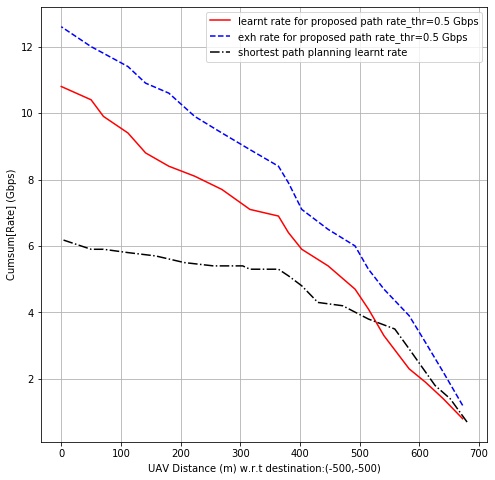

In [171]:
#Plot the figures
plt.figure(figsize=(8,8))
plt.clf()
plt.xlabel('UAV Distance (m) w.r.t destination:({0},{1})'.format(dest_loc[0],dest_loc[1]))
plt.ylabel('Cumsum[Rate] (Gbps)')

colors = ['blue','red','green']
i=1

exh_rate_change = np.array(ue_path_exh_rates[i][:-1])
short_rate_change = np.array(ue_short_path_rates[0][:-1])
#for i in range(len(models)-1):
learnt_rate_change = np.array(ue_path_rates[i][:-1])    
plt.plot(np.around(model_ue_dist[i][:-1], decimals=1), np.around(np.cumsum(learnt_rate_change), decimals=1), label='learnt rate for proposed path rate_thr={0} Gbps'.format(np.around(rate_thr[i], decimals=1)), color=colors[i])
plt.plot(np.around(model_ue_dist[i][:-1], decimals=1), np.around(np.cumsum(exh_rate_change), decimals=1), '--', color=colors[0], label='exh rate for proposed path rate_thr={0} Gbps'.format(np.around(rate_thr[i], decimals=1)))
plt.plot(np.around(ue_short_dist[:-1], decimals=1), np.around(np.cumsum(short_rate_change), decimals=1), '-.', color='black', label='shortest path planning learnt rate')
#plt.plot(ue_path_rates[i])
plt.grid()
plt.legend()
#plt.savefig('rate_distance_plot_051119.pdf')
plt.show()

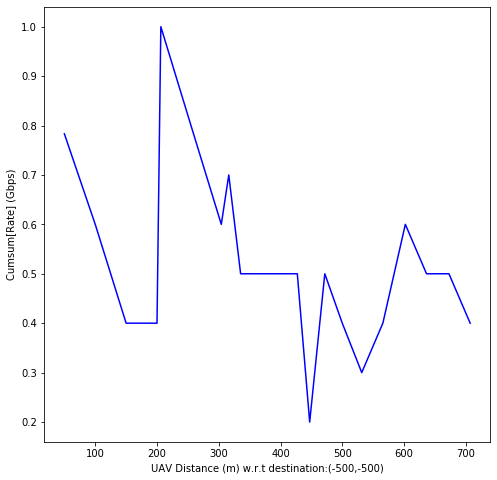

In [190]:
i=1
learnt_cumrates = np.cumsum(np.array(ue_path_rates[i][:-1]))
exh_cumrates = np.cumsum(np.array(ue_path_exh_rates[i][:-1]))
x = [np.sqrt(loc[0]**2+loc[1]**2) for loc in ue_paths[1]][:-1]
y1 = [learnt_cumrates[0]]
y2 = [exh_cumrates[0]]
for j in range(0,len(learnt_cumrates)-1):
    #print(learnt_cumrates[i+1]-learnt_cumrates[i])
    y1.append(np.around(learnt_cumrates[j+1]-learnt_cumrates[j], decimals=1))

plt.figure(figsize=(8,8))
plt.clf()
plt.xlabel('UAV Distance (m) w.r.t destination:({0},{1})'.format(dest_loc[0],dest_loc[1]))
plt.ylabel('Cumsum[Rate] (Gbps)')

plt.plot(np.around(x,decimals=1), y1, label='learnt rate for proposed path rate_thr={0} Gbps'.format(np.around(0.519, decimals=1)), color='blue')
#plt.plot(np.around(model_ue_dist[1][:-1],decimals=1), y2, label='learnt rate for proposed path rate_thr={0} Gbps'.format(np.around(0.519, decimals=1)), color='red')
plt.show()